## Add path and import libraries

In [1]:
import sys
sys.path.append('../../../') # Add the root directory to sys.path

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import ascii
from astropy.io.votable import parse_single_table
import ast
import glob

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

## Load and visualize data

In [7]:
test_dir = '../../../data/Gaia DR3/splits/test.parquet'
data = pd.read_parquet(test_dir)
data

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,spectraltype_esphs,Cat,flux
0,2270162933477596928,5793.526855,4.2239,-0.2202,F,LM,"[2.1406083e-17, 1.36527624e-17, 8.9983064e-18,..."
1,5595563490086213760,16123.186523,4.1203,-0.9216,B,LM,"[5.743483e-16, 5.6371223e-16, 5.316359e-16, 5...."
2,2062156877074076544,33753.062500,4.1338,-0.9648,B,M,"[9.540365e-16, 9.370028e-16, 8.942922e-16, 8.6..."
3,2266614878173081216,6153.653809,4.0231,-0.6670,F,LM,"[4.3227304e-17, 3.599028e-17, 3.1161376e-17, 3..."
4,2005083633660968704,16388.207031,3.7014,-0.0590,B,M,"[1.1341707e-15, 1.1049582e-15, 1.0222559e-15, ..."
...,...,...,...,...,...,...,...
3521,2263579951202517120,5750.221191,4.2642,-0.1881,G,LM,"[2.4816538e-17, 2.2245785e-17, 2.0786124e-17, ..."
3522,4094753787724436480,17691.224609,3.3499,0.2152,B,M,"[2.1005067e-14, 2.1114124e-14, 1.9657805e-14, ..."
3523,2268895780684642048,5785.978027,4.1548,-0.1405,G,LM,"[4.950771e-17, 4.735013e-17, 4.7743644e-17, 4...."
3524,5524705188351695744,22477.400391,3.7834,0.0073,B,M,"[4.0475476e-14, 4.102307e-14, 3.6672142e-14, 3..."


In [8]:
df = data.drop(columns = ['teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'spectraltype_esphs'])
df.head()

,source_id,Cat,flux
0,2270162933477596928,LM,"[2.1406083e-17, 1.36527624e-17, 8.9983064e-18,..."
1,5595563490086213760,LM,"[5.743483e-16, 5.6371223e-16, 5.316359e-16, 5...."
2,2062156877074076544,M,"[9.540365e-16, 9.370028e-16, 8.942922e-16, 8.6..."
3,2266614878173081216,LM,"[4.3227304e-17, 3.599028e-17, 3.1161376e-17, 3..."
4,2005083633660968704,M,"[1.1341707e-15, 1.1049582e-15, 1.0222559e-15, ..."


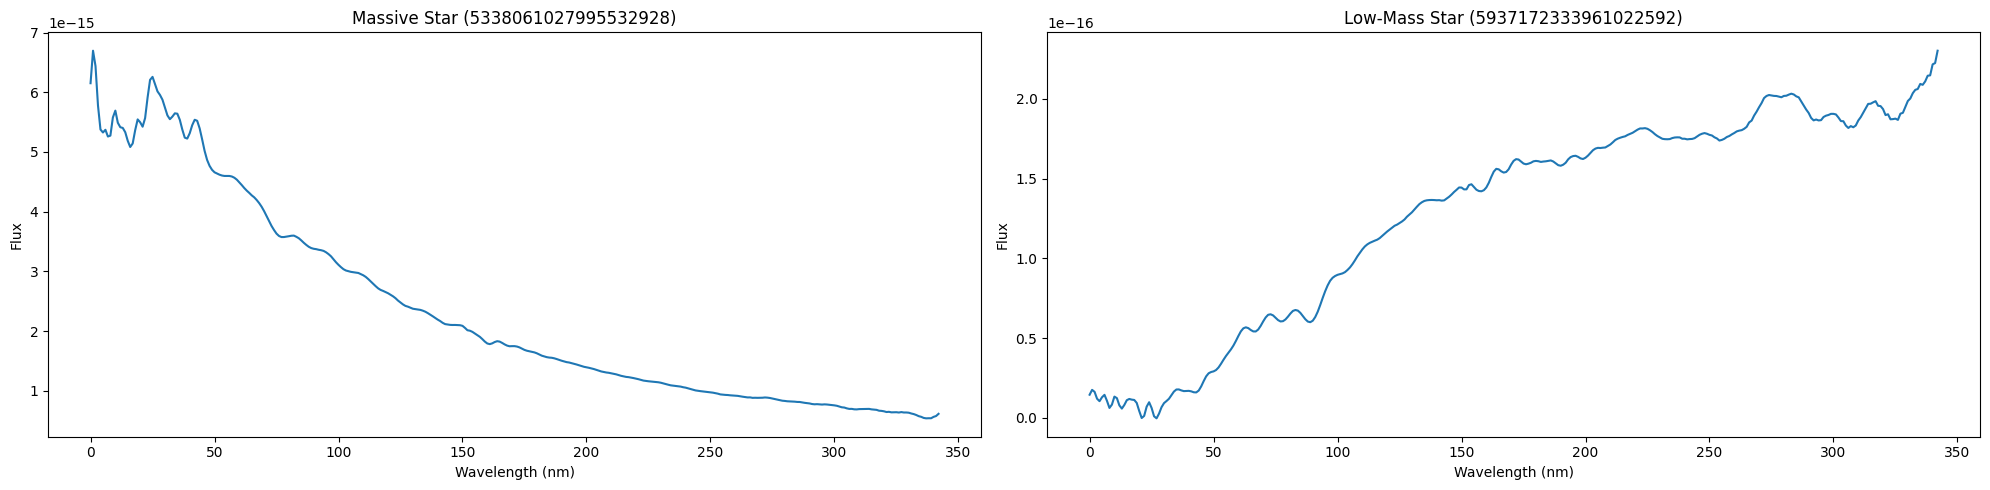

In [9]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = df[df['Cat'] == 'M'].sample(n=1).index
flux_ms = df['flux'].iloc[sample_ms].values[0]
object_id_ms = df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = df[df['Cat'] == 'LM'].sample(n=1).index
flux_lm = df['flux'].iloc[sample_lm].values[0]
object_id_lm = df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(20, 5))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')

plt.tight_layout()
plt.show()


In [10]:
num_samples = df.shape[0]
spectrum_width = len(df['flux'][0])

num_samples_lm = df['Cat'].value_counts()['LM']
num_samples_m = df['Cat'].value_counts()['M']
num_classes = df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 3526
Number of bins in each spectra: 343
In the dataset, we have 2206 spectra for low mass stars and 1320 spectra for high mass stars.


In [11]:
X = df['flux'].to_numpy()
y = df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X])).float()

## Add low mass samples (optional)

In [ ]:
test_dir = '../../../data/Gaia DR3/combined/LM_test.parquet'
df_lm = pd.read_parquet(test_dir)
df_lm

In [ ]:
final_df = pd.concat([df, df_lm]).reset_index(drop=True)
final_df

In [ ]:
final_df.info()

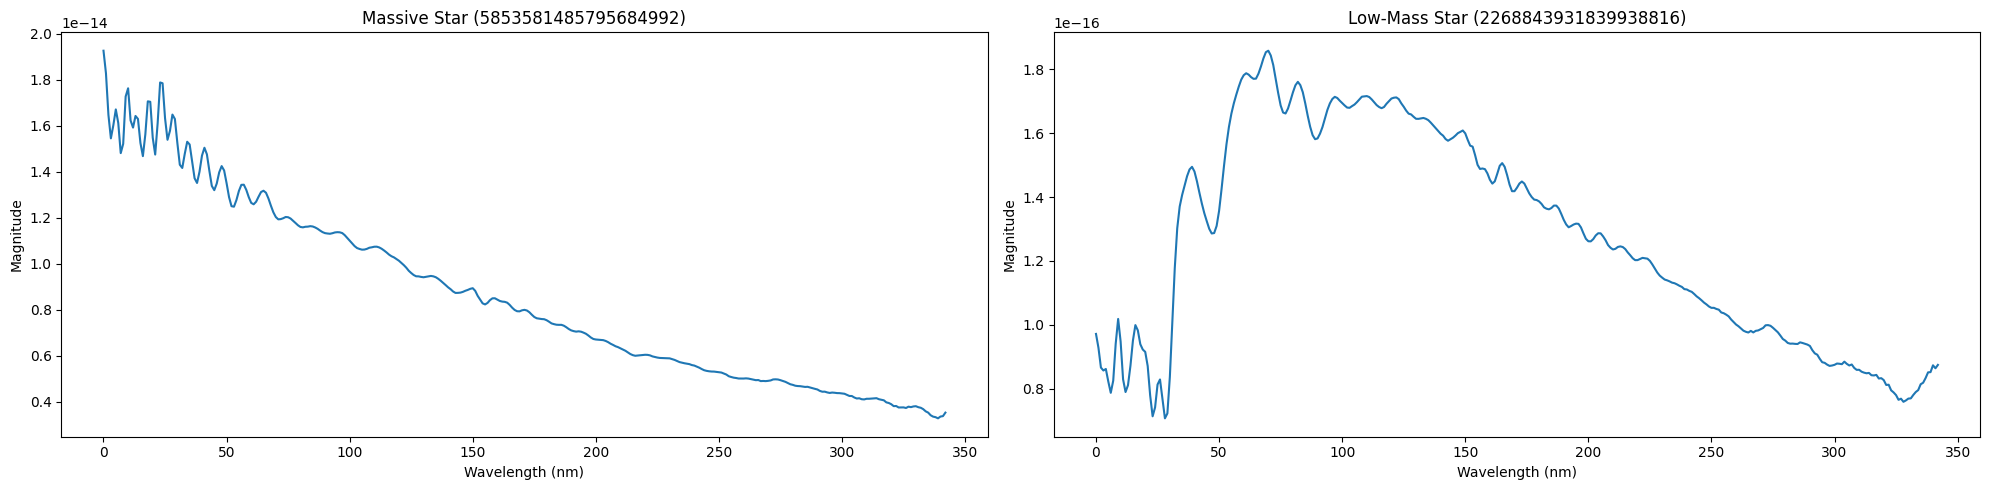

In [64]:
# rerun this cell to see random examples of different spectra


# Random sample from 'M' category (massive star)
sample_ms = final_df[final_df['Cat'] == 'M'].sample(n=1).index
flux_ms = final_df['flux'].iloc[sample_ms].values[0]
object_id_ms = final_df['source_id'].iloc[sample_ms].values[0]

# Random sample from 'LM' category (low-mass star)
sample_lm = final_df[final_df['Cat'] == 'LM'].sample(n=1).index
flux_lm = final_df['flux'].iloc[sample_lm].values[0]
object_id_lm = final_df['source_id'].iloc[sample_lm].values[0]

plt.figure(figsize=(20, 5))

# Plot for 'M' category (massive star)
plt.subplot(1, 2, 1)
plt.plot(flux_ms)
plt.title(f"Massive Star ({object_id_ms})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

# Plot for 'LM' category (low-mass star)
plt.subplot(1, 2, 2)
plt.plot(flux_lm)
plt.title(f"Low-Mass Star ({object_id_lm})")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [65]:
num_samples = final_df.shape[0]
spectrum_width = len(final_df['flux'][0])

num_samples_lm = final_df['Cat'].value_counts()['LM']
num_samples_m = final_df['Cat'].value_counts()['M']
num_classes = final_df['Cat'].nunique()

print("Number of total spectral samples:", num_samples)
print("Number of bins in each spectra:", spectrum_width)
print("In the dataset, we have", num_samples_lm, "spectra for low mass stars and", num_samples_m, "spectra for high mass stars.")

Number of total spectral samples: 13526
Number of bins in each spectra: 343
In the dataset, we have 12206 spectra for low mass stars and 1320 spectra for high mass stars.


In [66]:
X = final_df['flux'].to_numpy()
y = final_df['Cat'].to_numpy()

# encode categories to int
y = torch.from_numpy(np.where(y == 'M', 1, np.where(y == 'LM', 0, y)).astype(float))

# L2 normalization
X = torch.from_numpy(np.array([spectrum / np.linalg.norm(spectrum, keepdims=True) for spectrum in X])).float()

## Add noise to samples (optional)

In [16]:
def add_noise(spectra, noise_type='gaussian', level=0.005):
    if noise_type == 'gaussian':
        noise = np.random.normal(0, level, spectra.shape)
    elif noise_type == 'poisson':
        noise = np.random.poisson(spectra * level) / level - spectra
    elif noise_type == 'salt_pepper':
        noise = np.zeros(spectra.shape)
        salt = np.random.random(spectra.shape) < level/2
        pepper = np.random.random(spectra.shape) < level/2
        noise[salt] = 1
        noise[pepper] = -1
    return spectra + noise

def noisy_batch(X, noise_prob=1.0, **noise_params):
    mask = np.random.random(len(X)) < noise_prob
    X_noisy = X.copy()
    X_noisy[mask] = add_noise(X[mask], **noise_params)
    return X_noisy

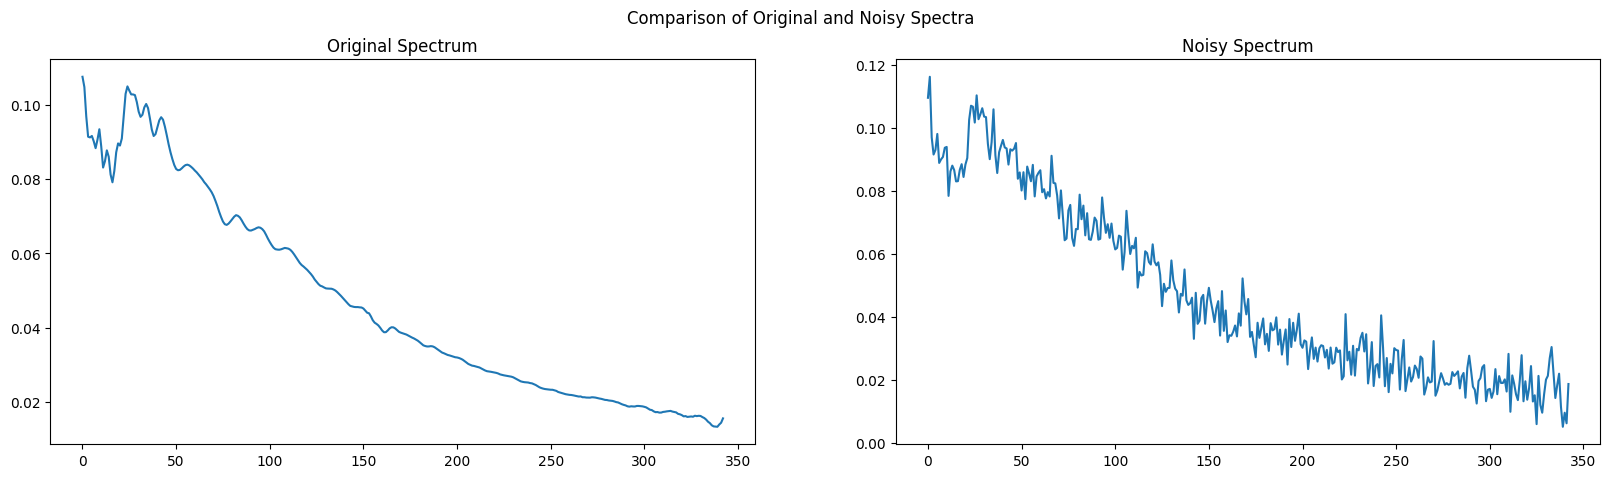

In [18]:
X_ = X
X = noisy_batch(np.array(X))

plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(X_[4])
ax1.set_title('Original Spectrum')
ax2 = plt.subplot(1, 2, 2)
ax2.plot(X[4])
ax2.set_title('Noisy Spectrum')
plt.suptitle('Comparison of Original and Noisy Spectra')

plt.show()


## Oversampling (optional)

In [21]:
smote = SMOTE(random_state=42)

X_new, y_new = smote.fit_resample(X, y)

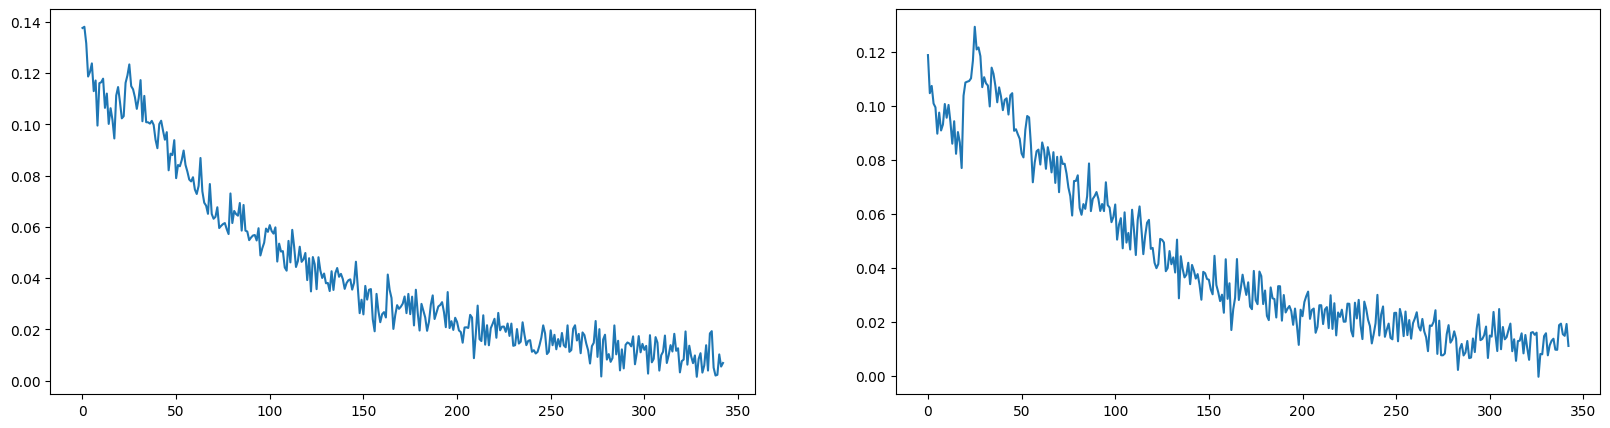

In [24]:
one_indices = np.where(y == 1.)[0]
random_index = np.random.choice(one_indices)

one_indices_new = np.where(y_new == 1.)[0]
random_index_new = np.random.choice(one_indices_new)

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(X[random_index])

plt.subplot(1,2,2)
plt.plot(X_new[random_index_new])

plt.show()

In [25]:
X, y = torch.from_numpy(X_new).float(), torch.from_numpy(y_new).float()

## Predicting

In [5]:
def predict(model, X, y, verbose=True):
    
    # hyperparameters
    device = 'cuda'
    
    for m in model:
        # move everything to gpu
        m.to(device)
        X = X.to(device)
        y = y.to(device).unsqueeze(1)
        
        # metrics
        accuracy = 0

        m.eval()
        preds, probs = [], []

        with torch.no_grad():
            
            output = m(X.unsqueeze(1))

            prob = torch.sigmoid(output)
            pred = torch.round(prob).cpu().numpy().astype(float)
            
            preds.extend(pred)
            probs.extend(prob.cpu().numpy())

        accuracy = accuracy_score(y.cpu().numpy(), preds)
        ra_score = roc_auc_score(y.cpu().numpy(), probs)
        f1 = f1_score(y.cpu().numpy(), preds)
        cm = confusion_matrix(y.cpu().numpy(), preds)
        
        return accuracy, ra_score, f1, cm

In [7]:
model = torch.load('../../trained_models/cnn_gpu.pth')

In [ ]:
accuracy, auc_score, f1, cm = predict(model, X, y)

single_sample = X[0].unsqueeze(0).unsqueeze(1)

Accuracy: 0.9694
AUC score: 0.9920
F1 score: 0.9600


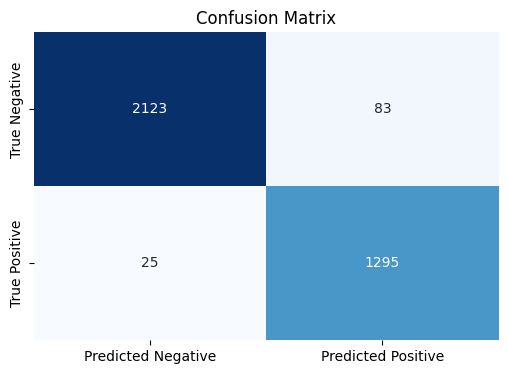

In [17]:
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC score: {auc_score:.4f}")
print(f"F1 score: {f1:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict(model, X, y, verbose=True):
    
    # hyperparameters
    device = 'cuda'
    
    for m in model:
        # move everything to gpu
        m.to(device)
        X = X.to(device)
        y = y.to(device).unsqueeze(1)
        
        # metrics
        accuracy = 0
        m.eval()
        preds, probs = [], []
        with torch.no_grad():
            
            output = m(X.unsqueeze(1))
            prob = torch.sigmoid(output)
            pred = torch.round(prob).cpu().numpy().astype(float) 
            
            preds.extend(pred.flatten())
            probs.extend(prob.cpu().numpy().flatten())
        
        preds = np.array(preds)
        probs = np.array(probs)
        y_np = y.cpu().numpy().flatten()
        
        accuracy = accuracy_score(y_np, preds)
        ra_score = roc_auc_score(y_np, probs)
        f1 = f1_score(y_np, preds)
        cm = confusion_matrix(y_np, preds)
        
        incorrect_mask = preds != y_np
        incorrect_probs = probs[incorrect_mask]
        incorrect_true_labels = y_np[incorrect_mask]
        
        return accuracy, ra_score, f1, cm, incorrect_probs, incorrect_true_labels

model = torch.load('../../trained_models/cnn_gpu.pth')
accuracy, auc_score, f1, cm, incorrect_probs, incorrect_true_labels = predict(model, X, y)

high_confidence_fp = 0
low_confidence_fn = 0

for prob, true_label in zip(incorrect_probs, incorrect_true_labels):
    predicted_label = 1 if prob > 0.5 else 0
    
    if true_label == 0 and prob > 0.90:
        high_confidence_fp += 1
    elif true_label == 1 and prob < 0.10:
        low_confidence_fn += 1
    
    #print(f"True label: {true_label}, Predicted probability: {prob:.4f}, Incorrectly predicted as: {predicted_label}")

total_incorrect = len(incorrect_probs)
print("Report:\n")
print(f"Total incorrect predictions: {total_incorrect}")
print(f"High confidence false positives (prob > 0.90): {high_confidence_fp} ({high_confidence_fp/total_incorrect:.2%})")
print(f"High confidence false negatives (prob < 0.10): {low_confidence_fn} ({low_confidence_fn/total_incorrect:.2%})")

Report:

Total incorrect predictions: 108
High confidence false positives (prob > 0.90): 30 (27.78%)
High confidence false negatives (prob < 0.10): 9 (8.33%)


In [19]:
def predict(model, X, y, pos_threshold=0.9, neg_threshold=0.1, verbose=True):
    
    # hyperparameters
    device = 'cuda'
    
    for m in model:
        # move everything to gpu
        m.to(device)
        X = X.to(device)
        y = y.to(device).unsqueeze(1)
        
        m.eval()
        preds, probs = [], []
        with torch.no_grad():
            
            output = m(X.unsqueeze(1))
            prob = torch.sigmoid(output)
            pred = torch.where(prob > pos_threshold, torch.tensor(1.0).to(device),
                               torch.where(prob < neg_threshold, torch.tensor(0.0).to(device),
                                           torch.tensor(float('nan')).to(device)))
            
            preds.extend(pred.cpu().numpy().flatten())
            probs.extend(prob.cpu().numpy().flatten())
        
        preds = np.array(preds)
        probs = np.array(probs)
        y_np = y.cpu().numpy().flatten()
        
        valid_mask = ~np.isnan(preds)
        preds = preds[valid_mask]
        probs = probs[valid_mask]
        y_valid = y_np[valid_mask]
        
        accuracy = accuracy_score(y_valid, preds)
        ra_score = roc_auc_score(y_valid, probs)
        f1 = f1_score(y_valid, preds)
        cm = confusion_matrix(y_valid, preds)
        
        incorrect_mask = preds != y_valid
        incorrect_probs = probs[incorrect_mask]
        incorrect_true_labels = y_valid[incorrect_mask]
        
        return accuracy, ra_score, f1, cm, incorrect_probs, incorrect_true_labels, valid_mask

model = torch.load('../../trained_models/cnn_gpu.pth')
accuracy, auc_score, f1, cm, incorrect_probs, incorrect_true_labels, valid_mask = predict(model, X, y)

high_confidence_fp = sum((incorrect_probs > 0.9) & (incorrect_true_labels == 0))
low_confidence_fn = sum((incorrect_probs < 0.1) & (incorrect_true_labels == 1))

total_incorrect = len(incorrect_probs)
print(f"\nTotal incorrect predictions: {total_incorrect}")
print(f"High confidence false positives (prob > 0.9): {high_confidence_fp} ({high_confidence_fp/total_incorrect:.2%})")
print(f"Low confidence false negatives (prob < 0.1): {low_confidence_fn} ({low_confidence_fn/total_incorrect:.2%})")

total_samples = len(valid_mask)
uncertain_samples = sum(~valid_mask)
print(f"\nTotal samples: {total_samples}")
print(f"Samples in uncertainty region (0.1 <= prob <= 0.9): {uncertain_samples} ({uncertain_samples/total_samples:.2%})")


Total incorrect predictions: 39
High confidence false positives (prob > 0.9): 30 (76.92%)
Low confidence false negatives (prob < 0.1): 9 (23.08%)

Total samples: 3526
Samples in uncertainty region (0.1 <= prob <= 0.9): 272 (7.71%)


## Inferencing

In [43]:
ext_sources = '../../../data/Gaia DR3/external'
files = glob.glob(f'{ext_sources}/*.csv')
for f in files:
    ext_data = ascii.read(f, guess=False, delimiter=',').to_pandas()

In [11]:
impartial_sources = '../../../data/Gaia DR3/spectra/XP_temp'
files = glob.glob(f'{impartial_sources}/*.vot')
combined_df = pd.DataFrame()
for f in files[:10]:
    impartial_data = parse_single_table(f).to_table().to_pandas()['flux']
    combined_df = pd.concat([combined_df, impartial_data], ignore_index=True, axis=1)

In [12]:
combined_df

,0,1,2,3,4,5,6,7,8,9
0,6.129230e-18,7.833916e-16,4.339317e-16,-2.017698e-17,8.479949e-17,1.412043e-17,9.175369e-17,1.287120e-17,7.706357e-18,3.342867e-16
1,5.883068e-18,7.036686e-16,3.027837e-16,-3.659598e-18,1.480293e-16,1.265187e-17,1.018683e-16,8.222620e-18,6.079910e-18,3.105649e-16
2,3.526800e-18,9.255116e-16,2.951619e-16,1.407424e-17,2.182841e-16,1.226100e-17,9.462838e-17,9.097892e-18,8.513194e-18,2.002580e-16
3,3.933119e-18,7.218780e-16,1.672529e-16,5.365206e-18,1.382704e-16,1.208753e-17,7.257923e-17,9.401625e-18,9.905569e-18,1.134231e-16
4,5.798774e-18,4.002153e-16,1.039799e-16,-8.574184e-18,8.141185e-17,1.162928e-17,5.586281e-17,7.339797e-18,9.344781e-18,1.332130e-16
...,...,...,...,...,...,...,...,...,...,...
338,2.149378e-15,4.313129e-13,8.967198e-14,2.347223e-14,1.301453e-13,5.471464e-17,2.139661e-14,7.933150e-15,4.028755e-17,5.071515e-14
339,2.168386e-15,4.344676e-13,9.008698e-14,2.431167e-14,1.318486e-13,5.456801e-17,2.149900e-14,8.017369e-15,4.050512e-17,5.188462e-14
340,2.236761e-15,4.487032e-13,9.244867e-14,2.571466e-14,1.371105e-13,5.623187e-17,2.212399e-14,8.302618e-15,4.213362e-17,5.399247e-14
341,2.224279e-15,4.477487e-13,9.131628e-14,2.618286e-14,1.379818e-13,5.647237e-17,2.197297e-14,8.307575e-15,4.273822e-17,5.380273e-14


In [34]:
X_inference = torch.from_numpy(np.array([np.array(ast.literal_eval(x)) for x in ext_data['flux']])).float()

In [35]:
X_inference

tensor([[1.4239e-16, 1.3138e-16, 1.2891e-16,  ..., 1.7960e-16, 1.8458e-16,
         1.9718e-16],
        [5.0583e-17, 5.2201e-17, 3.6561e-17,  ..., 8.3875e-17, 8.5337e-17,
         9.0395e-17],
        [5.6101e-17, 5.4696e-17, 5.3000e-17,  ..., 5.3675e-17, 5.5097e-17,
         5.9610e-17],
        ...,
        [2.5006e-17, 1.3638e-17, 9.0405e-18,  ..., 1.7124e-16, 1.7300e-16,
         1.7989e-16],
        [1.7409e-16, 1.5042e-16, 1.5927e-16,  ..., 1.4918e-16, 1.5683e-16,
         1.7326e-16],
        [4.1347e-17, 5.3269e-17, 4.8477e-17,  ..., 6.6335e-17, 6.5946e-17,
         6.7308e-17]])

In [36]:
def inference(model, X):
    print("Starting inference")
    for m in model:
        m.eval()
        with torch.no_grad():
            print(f"Input shape: {X.shape}")
            output = m(X.unsqueeze(1))
            prob = torch.sigmoid(output)
            prediction = torch.round(prob).numpy().astype(float)
            print(f"Inference completed. Prediction shape: {prediction.shape}")
            return prediction
        
preds = inference(model, X_inference)

Starting inference
Input shape: torch.Size([22058, 343])
Inference completed. Prediction shape: (22058, 1)


In [40]:
np.unique(preds)

array([0.])